# Handwritten Digit Recognition using Softmax, Perceptron, and Linear Regression

---

## Developer
**Boris Teplitskiy**

---

## Project Description
This project focuses on developing machine learning algorithms to classify handwritten digits from the MNIST dataset. The following methods were implemented:

- **Linear Regression:** Used for predicting numerical values and adapting them for classification tasks.
- **Perceptron:** A fundamental classification algorithm using the one-vs-all strategy for multi-class problems.
- **Softmax Regression:** A probabilistic model for multi-class classification, estimating the likelihood of digits belonging to one of the 10 classes.

The project emphasizes theoretical understanding and practical implementation without the use of pre-built machine learning models.

---

## Project Goals
- Explore and implement algorithms for linear regression, perceptron, and softmax regression.
- Compare the performance of different approaches in the classification task.
- Develop vectorized implementations to enhance computational efficiency.
- Analyze evaluation metrics (accuracy, sensitivity, and confusion matrix) for each digit.

---

## Tools and Technologies
- **Programming Language:** Python
- **Environment:** Google Clab
- **Libraries:** NumPy, Matplotlib, Pandas,Sklearn,seaborn,tqdm



## Contact Information
 
- **Email:** teplitskiyb@gmail.com

---





##Introduction

The objective of this project is to implement and evaluate three different machine learning algorithms—Perceptron with Pocket Algorithm, Softmax Regression, and Linear Regression—for the task of classifying handwritten digits from the MNIST dataset. This study aims to compare the performance of these models in terms of accuracy, computational efficiency, and suitability for multi-class classification problems.

---
#***Importing Necessary Libraries***
First, we need to import all the necessary Python libraries required for data handling, visualization, and implementing the machine learning models.

---

In [93]:
# Standard Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-learn for data loading and evaluation metrics
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# tqdm for progress bars
from tqdm import tqdm
import random


---
#***Data Loading and Preprocessing***

Fetching the MNIST Dataset
We will use the fetch_openml function from scikit-learn to download the MNIST dataset.

---

In [94]:
# Function to fetch MNIST dataset
def fetch_mnist():
    """
    Fetches the MNIST dataset from OpenML.

    Returns
    -------
    X : np.ndarray
        Feature matrix of shape (70000, 784).
    y : np.ndarray
        Labels of shape (70000,).
    """
    mnist = fetch_openml('mnist_784', version=1,)
    X, y = mnist['data'], mnist['target'].astype(int)
    return X, y

# Load the data
X, y = fetch_mnist()


___
###Data Normalization

Normalize the feature values to the range [0, 1] to improve the efficiency and stability of the training process.

We normalize data for Perceptron, Softmax regression, and Linear regression because:

- Equal Feature Contribution: Prevents features with larger scales from dominating the model’s computations, ensuring balanced weight updates.

- Numerical Stability: Avoids overflow or underflow in operations like exponentiation (Softmax) or matrix inversion (Linear Regression).

- Faster Convergence: Gradient-based methods like Perceptron and Softmax regression converge faster when features are scaled consistently.

- Better Predictions: Improves the conditioning of the feature matrix, leading to more accurate and stable results.
___

In [95]:
# Normalize the feature values to [0, 1]
X = X / 255.0


___
### Adding Bias Term
Add a bias term by inserting a column of ones at the beginning of the feature matrix. This allows the model to learn the intercept term.
___



In [96]:
# Add bias term by inserting a column of ones at the beginning
X = np.hstack((np.ones((X.shape[0], 1)), X))  # Shape: (70000, 785)


---
###Splitting the Dataset
Divide the dataset into training and test sets. The training set contains 60,000 samples, and the test set contains 10,000 samples.

---

In [97]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)


---
## Utility Functions

This block contains utility functions for common tasks such as one-hot encoding of class labels and calculating accuracy.

- `learning_rate_schedule(iteration, initial_lr, decay_rate)` :
  - The learning rate decay (damping) is implemented to stabilize the weight updates. In the early stages, large updates help quickly reduce errors, but as the model approaches the optimal solution, a high learning rate can cause "jagged error graphs" where the algorithm overshoots the minimum and fails to converge.

A smaller learning rate in later stages smooths the updates, reducing the amplitude of oscillations (envelope). This allows the algorithm to fine-tune the decision boundary and avoid chaotic weight behavior.
PS : used in Preceptron only


A function for analyzing results, confusion matrix metrics, and their visualization.
- `plot_confusion_matrix`
- `calculate_metrics`
- `plot_per_class_confusion_matrices`
- `display_metrics_table`
- `classification_report_and_matrix`

---


In [98]:
def learning_rate_schedule(iteration, initial_lr, decay_rate):
    switch_iter=100 # optinal choise  for 1000  iteractions
    if iteration >=  switch_iter:

        return initial_lr / (1 + decay_rate * iteration)
    else:

        return initial_lr / (1 + (decay_rate/15 ) * iteration)


In [99]:
def plot_confusion_matrix(y_test, y_pred):
    """
    Plot the confusion matrix.

    :param y_test: True labels (n_samples,)
    :param y_pred: Predicted labels (n_samples,)
    """
    cm = confusion_matrix(y_test, y_pred)
    n_classes = cm.shape[0]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Classes")
    plt.ylabel("True Classes")
    plt.show()


def calculate_metrics(y_test, y_pred):
    """
    Calculate performance metrics for each class.

    :param y_test: True labels (n_samples,)
    :param y_pred: Predicted labels (n_samples,)
    :return: Dictionary containing metrics for each class
    """
    cm = confusion_matrix(y_test, y_pred)
    n_classes = cm.shape[0]
    total_samples = np.sum(cm)
    metrics = {
        "Class": [],
        "Accuracy": [],
        "Sensitivity (TPR)": [],
        "Specificity (TNR)": [],
        "TP": [],
        "FP": [],
        "TN": [],
        "FN": []
    }

    for i in range(n_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = total_samples - (TP + FP + FN)

        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

        metrics["Class"].append(i)
        metrics["Accuracy"].append(round(accuracy, 5))
        metrics["Sensitivity (TPR)"].append(round(sensitivity, 5))
        metrics["Specificity (TNR)"].append(round(specificity, 5))
        metrics["TP"].append(TP)
        metrics["FP"].append(FP)
        metrics["TN"].append(TN)
        metrics["FN"].append(FN)

    return metrics


def plot_per_class_confusion_matrices(y_test, y_pred):
    """
    Plot confusion sub-matrices for each class.

    :param y_test: True labels (n_samples,)
    :param y_pred: Predicted labels (n_samples,)
    """
    cm = confusion_matrix(y_test, y_pred)
    n_classes = cm.shape[0]
    total_samples = np.sum(cm)
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i in range(n_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = total_samples - (TP + FP + FN)

        sub_matrix = np.array([[TP, FN], [FP, TN]])
        sns.heatmap(sub_matrix, annot=True, fmt='d', cmap='coolwarm', ax=axes[i], cbar=False)
        axes[i].set_title(f"Class {i}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


def display_metrics_table(y_test, y_pred):
    """
    Display the classification metrics in a table format.

    :param y_test: True labels (n_samples,)
    :param y_pred: Predicted labels (n_samples,)
    """
    cm = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(y_test, y_pred)
    overall_accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) != 0 else 0

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')

    table_data = [
        [metrics["Class"][i], metrics["Accuracy"][i], metrics["Sensitivity (TPR)"][i],
         metrics["Specificity (TNR)"][i], metrics["TP"][i], metrics["FP"][i],
         metrics["TN"][i], metrics["FN"][i]] for i in range(len(metrics["Class"]))
    ]

    column_labels = ["Class", "Accuracy", "Sensitivity (TPR)", "Specificity (TNR)", "TP", "FP", "TN", "FN"]
    table = ax.table(cellText=table_data, colLabels=column_labels, loc="center", cellLoc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.title(f"Classification Report - Overall Accuracy: {overall_accuracy:.5f}")
    plt.show()


def classification_report_and_matrix(y_test, y_pred):
    """
    Main function to generate confusion matrix, visualize it, and calculate performance metrics.

    :param y_test: True labels (n_samples,)
    :param y_pred: Predicted labels (n_samples,)
    """
    plot_confusion_matrix(y_test, y_pred)
    plot_per_class_confusion_matrices(y_test, y_pred)
    display_metrics_table(y_test, y_pred)


#**Model Implementations**
---


#***Perceptron with Pocket Algorithm***:

The Perceptron with Pocket Algorithm is an extension of the basic Perceptron that retains the best-performing weight vector encountered during training. This helps in handling cases where the data is not linearly separable.
---

In [100]:
class PerceptronWithPocketForMulticlass:
    def __init__(self, num_classes, max_iter=1000, verbose=False, random_seed=None, initial_lr=0.1, decay_rate=0.25):
        """
        Initialize the PerceptronWithPocketForMulticlass model.

        Parameters:
        - num_classes (int): Number of classes in the dataset.
        - max_iter (int): Maximum number of iterations for training each perceptron.
        - verbose (bool): If True, display detailed logs during training.
        - random_seed (int, optional): Seed for random weight initialization (ensures reproducibility).
        - initial_lr (float): Initial learning rate for weight updates.
        - decay_rate (float): Rate at which the learning rate decays during training.
        """
        self.num_classes = num_classes
        self.max_iter = max_iter
        self.verbose = verbose
        self.random_seed = random_seed
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.classifiers = {}  # Stores the "pocket" weights for each class
        self.errors_histories = {}  # Stores error history for each class
        if random_seed is not None:
            np.random.seed(random_seed)
    def fit(self, X_train, y_train):
        """
        Train the perceptrons for all classes using a "one-vs-all" strategy.

        Parameters:
        - X_train (np.ndarray): Feature matrix of shape (n_samples, n_features).
        - y_train (np.ndarray): Target labels of shape (n_samples,).

        Returns:
        - self: Trained model instance.
        """
        from tqdm import tqdm

        # Outer loop: Train a separate perceptron for each class
        for digit in tqdm(range(self.num_classes), desc="Training Classes", disable=not self.verbose):
            if self.verbose:
                print(f"\nTraining Perceptron for digit {digit} vs all others...")

            # Convert labels to binary: 1 for the current class, -1 for all others
            y_train_binary = np.where(y_train == digit, 1, -1)

            # Shuffle function to randomize data
            def shuffle_binary(X, y):
                indices = np.arange(X.shape[0])
                np.random.shuffle(indices)
                return X[indices], y[indices]

            # Shuffle training data
            X_train_binary, y_train_binary = shuffle_binary(X_train, y_train_binary)

            # Initialize weights and pocket variables
            w = np.random.uniform(-0.01, 0.01, X_train.shape[1])
            # Explanation: Weights are initialized with small random values in the range [-0.01, 0.01] to break symmetry
            # between different features and ensure that the initial predictions are not biased towards any particular class.
            # This randomness helps the perceptron learn distinct decision boundaries.

            w_pocket = w.copy()
            min_errors = np.inf
            errors_history = []

            # Inner loop: Perform weight updates for max_iter iterations
            for iteration in tqdm(range(self.max_iter), desc=f"Training Digit {digit}", leave=False, disable=True ):
                # Compute scores and predictions
                scores = X_train_binary @ w
                predictions = np.sign(scores)
                predictions[predictions == 0] = -1  # Treat zero as -1

                # Identify misclassified samples
                mask = y_train_binary * predictions <= 0
                misclassified = np.where(mask)[0]
                current_errors = len(misclassified)
                errors_history.append(current_errors)

                # Log progress every 100 iterations
                if self.verbose and iteration % 100 == 0:
                    print(f"Digit {digit} - Iteration {iteration + 1}: Min Errors = {min_errors}, Current Errors = {current_errors}")

                # Update pocket weights if current errors are fewer
                if current_errors < min_errors:
                    min_errors = current_errors
                    w_pocket = w.copy()

                # Compute learning rate with a decay schedule
                self.learning_rate = learning_rate_schedule(iteration, self.initial_lr, self.decay_rate)

                # Shuffle misclassified samples before updating weights
                X_misclassified, y_misclassified = shuffle_binary(X_train_binary[misclassified], y_train_binary[misclassified])
                # Explanation: Shuffling misclassified samples ensures that updates are not influenced by the order of
                # presentation of the data. This prevents the perceptron from overfitting to specific patterns in the
                # sequence of the misclassified samples and enhances the model's ability to generalize.

                # Update weights using misclassified samples
                delta_w = self.learning_rate * (y_misclassified[:, np.newaxis] * X_misclassified).sum(axis=0)
                # Explanation: The weight update is computed as a sum of feature vectors of the misclassified samples,
                # scaled by their labels and the learning rate. This process adjusts the weights to correctly classify
                # the misclassified samples in the next iteration, aligning the decision boundary closer to the optimal position.
                w += delta_w

            # Store the best weights (pocket) for the current digit
            self.classifiers[digit] = w_pocket
            self.errors_histories[digit] = errors_history

        return self

    def score( self,X, y):
        """
        Calculate the accuracy of the model on the given data.

        Parameters
        ----------
        X : np.ndarray
            Feature matrix (shape: n_samples, n_features).
        y : np.ndarray
            True labels (shape: n_samples,).

        Returns
        -------
        float
            Accuracy score (0 to 1).
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


    def predict(self, X):
        """
        Predict labels for the given data.

        Parameters:
        - X (np.ndarray): Feature matrix of shape (n_samples, n_features).

        Returns:
        - np.ndarray: Predicted labels of shape (n_samples,).
        """
        # Stack the pocket weights for all classes into a single matrix
        W = np.array([self.classifiers[digit] for digit in range(self.num_classes)]).T

        # Compute scores for each class and predict the class with the highest score
        scores = X @ W
        return np.argmax(scores, axis=1)

    def plot_error_histories(self):
        """
        Plot error histories for all classes.
        """


        # Create subplots for all classes (assuming 10 classes, 2 rows x 5 columns)
        fig, axes = plt.subplots(2, 5, figsize=(20, 10))
        fig.suptitle("Error Histories for Each Digit - Perceptron with Pocket Algorithm", fontsize=16)

        for digit in range(self.num_classes):
            row, col = divmod(digit, 5)
            ax = axes[row, col]

            # Plot error history for the current digit
            errors = self.errors_histories[digit]
            ax.plot(errors, label=f'Digit {digit}', color='blue')
            ax.set_title(f"Digit {digit}")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Number of Errors")
            ax.legend()
            ax.grid(True)

        # Adjust layout and display the plots
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

###Training Perceptron with Pocket Algorithm


In [101]:
perceptron_model = PerceptronWithPocketForMulticlass(num_classes=10, max_iter=1000, initial_lr=0.2, decay_rate=0.4, verbose=True, random_seed=42)
perceptron_model.fit(X_train, y_train)

Training Classes:   0%|          | 0/10 [00:00<?, ?it/s]


Training Perceptron for digit 0 vs all others...
Digit 0 - Iteration 1: Min Errors = inf, Current Errors = 48635
Digit 0 - Iteration 101: Min Errors = 832, Current Errors = 830
Digit 0 - Iteration 201: Min Errors = 813, Current Errors = 813
Digit 0 - Iteration 301: Min Errors = 805, Current Errors = 805
Digit 0 - Iteration 401: Min Errors = 796, Current Errors = 801
Digit 0 - Iteration 501: Min Errors = 796, Current Errors = 798
Digit 0 - Iteration 601: Min Errors = 795, Current Errors = 796
Digit 0 - Iteration 701: Min Errors = 795, Current Errors = 795
Digit 0 - Iteration 801: Min Errors = 792, Current Errors = 792
Digit 0 - Iteration 901: Min Errors = 792, Current Errors = 792


Training Classes:  10%|█         | 1/10 [00:39<05:55, 39.45s/it]


Training Perceptron for digit 1 vs all others...
Digit 1 - Iteration 1: Min Errors = inf, Current Errors = 21474
Digit 1 - Iteration 101: Min Errors = 650, Current Errors = 649
Digit 1 - Iteration 201: Min Errors = 644, Current Errors = 645
Digit 1 - Iteration 301: Min Errors = 640, Current Errors = 640
Digit 1 - Iteration 401: Min Errors = 638, Current Errors = 639
Digit 1 - Iteration 501: Min Errors = 638, Current Errors = 639
Digit 1 - Iteration 601: Min Errors = 634, Current Errors = 634
Digit 1 - Iteration 701: Min Errors = 634, Current Errors = 634
Digit 1 - Iteration 801: Min Errors = 633, Current Errors = 635
Digit 1 - Iteration 901: Min Errors = 632, Current Errors = 632


Training Classes:  20%|██        | 2/10 [01:15<04:58, 37.31s/it]


Training Perceptron for digit 2 vs all others...
Digit 2 - Iteration 1: Min Errors = inf, Current Errors = 28956
Digit 2 - Iteration 101: Min Errors = 1430, Current Errors = 1432
Digit 2 - Iteration 201: Min Errors = 1422, Current Errors = 1421
Digit 2 - Iteration 301: Min Errors = 1412, Current Errors = 1414
Digit 2 - Iteration 401: Min Errors = 1412, Current Errors = 1415
Digit 2 - Iteration 501: Min Errors = 1407, Current Errors = 1408
Digit 2 - Iteration 601: Min Errors = 1404, Current Errors = 1405
Digit 2 - Iteration 701: Min Errors = 1402, Current Errors = 1403
Digit 2 - Iteration 801: Min Errors = 1400, Current Errors = 1404
Digit 2 - Iteration 901: Min Errors = 1400, Current Errors = 1404


Training Classes:  30%|███       | 3/10 [01:58<04:39, 39.89s/it]


Training Perceptron for digit 3 vs all others...
Digit 3 - Iteration 1: Min Errors = inf, Current Errors = 26601
Digit 3 - Iteration 101: Min Errors = 1792, Current Errors = 1793
Digit 3 - Iteration 201: Min Errors = 1777, Current Errors = 1778
Digit 3 - Iteration 301: Min Errors = 1755, Current Errors = 1754
Digit 3 - Iteration 401: Min Errors = 1749, Current Errors = 1752
Digit 3 - Iteration 501: Min Errors = 1749, Current Errors = 1751
Digit 3 - Iteration 601: Min Errors = 1743, Current Errors = 1743
Digit 3 - Iteration 701: Min Errors = 1739, Current Errors = 1740
Digit 3 - Iteration 801: Min Errors = 1730, Current Errors = 1730
Digit 3 - Iteration 901: Min Errors = 1728, Current Errors = 1730


Training Classes:  40%|████      | 4/10 [02:44<04:14, 42.49s/it]


Training Perceptron for digit 4 vs all others...
Digit 4 - Iteration 1: Min Errors = inf, Current Errors = 29509
Digit 4 - Iteration 101: Min Errors = 1290, Current Errors = 1290
Digit 4 - Iteration 201: Min Errors = 1283, Current Errors = 1283
Digit 4 - Iteration 301: Min Errors = 1273, Current Errors = 1273
Digit 4 - Iteration 401: Min Errors = 1270, Current Errors = 1270
Digit 4 - Iteration 501: Min Errors = 1261, Current Errors = 1261
Digit 4 - Iteration 601: Min Errors = 1256, Current Errors = 1256
Digit 4 - Iteration 701: Min Errors = 1253, Current Errors = 1253
Digit 4 - Iteration 801: Min Errors = 1250, Current Errors = 1250
Digit 4 - Iteration 901: Min Errors = 1247, Current Errors = 1247


Training Classes:  50%|█████     | 5/10 [03:26<03:31, 42.34s/it]


Training Perceptron for digit 5 vs all others...
Digit 5 - Iteration 1: Min Errors = inf, Current Errors = 33303
Digit 5 - Iteration 101: Min Errors = 2054, Current Errors = 2044
Digit 5 - Iteration 201: Min Errors = 2012, Current Errors = 2012
Digit 5 - Iteration 301: Min Errors = 1997, Current Errors = 1998
Digit 5 - Iteration 401: Min Errors = 1986, Current Errors = 1987
Digit 5 - Iteration 501: Min Errors = 1979, Current Errors = 1981
Digit 5 - Iteration 601: Min Errors = 1974, Current Errors = 1977
Digit 5 - Iteration 701: Min Errors = 1971, Current Errors = 1971
Digit 5 - Iteration 801: Min Errors = 1971, Current Errors = 1972
Digit 5 - Iteration 901: Min Errors = 1971, Current Errors = 1974


Training Classes:  60%|██████    | 6/10 [04:13<02:55, 43.83s/it]


Training Perceptron for digit 6 vs all others...
Digit 6 - Iteration 1: Min Errors = inf, Current Errors = 52571
Digit 6 - Iteration 101: Min Errors = 1127, Current Errors = 1125
Digit 6 - Iteration 201: Min Errors = 1113, Current Errors = 1113
Digit 6 - Iteration 301: Min Errors = 1107, Current Errors = 1107
Digit 6 - Iteration 401: Min Errors = 1098, Current Errors = 1098
Digit 6 - Iteration 501: Min Errors = 1093, Current Errors = 1095
Digit 6 - Iteration 601: Min Errors = 1093, Current Errors = 1093
Digit 6 - Iteration 701: Min Errors = 1090, Current Errors = 1090
Digit 6 - Iteration 801: Min Errors = 1088, Current Errors = 1088
Digit 6 - Iteration 901: Min Errors = 1088, Current Errors = 1089


Training Classes:  70%|███████   | 7/10 [04:54<02:08, 42.92s/it]


Training Perceptron for digit 7 vs all others...
Digit 7 - Iteration 1: Min Errors = inf, Current Errors = 10844
Digit 7 - Iteration 101: Min Errors = 1125, Current Errors = 1121
Digit 7 - Iteration 201: Min Errors = 1107, Current Errors = 1107
Digit 7 - Iteration 301: Min Errors = 1105, Current Errors = 1106
Digit 7 - Iteration 401: Min Errors = 1100, Current Errors = 1101
Digit 7 - Iteration 501: Min Errors = 1100, Current Errors = 1101
Digit 7 - Iteration 601: Min Errors = 1100, Current Errors = 1100
Digit 7 - Iteration 701: Min Errors = 1096, Current Errors = 1098
Digit 7 - Iteration 801: Min Errors = 1095, Current Errors = 1098
Digit 7 - Iteration 901: Min Errors = 1093, Current Errors = 1094


Training Classes:  80%|████████  | 8/10 [05:34<01:24, 42.04s/it]


Training Perceptron for digit 8 vs all others...
Digit 8 - Iteration 1: Min Errors = inf, Current Errors = 47992
Digit 8 - Iteration 101: Min Errors = 2700, Current Errors = 3305
Digit 8 - Iteration 201: Min Errors = 2700, Current Errors = 2845
Digit 8 - Iteration 301: Min Errors = 2700, Current Errors = 2825
Digit 8 - Iteration 401: Min Errors = 2700, Current Errors = 2806
Digit 8 - Iteration 501: Min Errors = 2700, Current Errors = 2810
Digit 8 - Iteration 601: Min Errors = 2700, Current Errors = 2799
Digit 8 - Iteration 701: Min Errors = 2700, Current Errors = 2788
Digit 8 - Iteration 801: Min Errors = 2700, Current Errors = 2794
Digit 8 - Iteration 901: Min Errors = 2700, Current Errors = 2782


Training Classes:  90%|█████████ | 9/10 [06:28<00:45, 45.64s/it]


Training Perceptron for digit 9 vs all others...
Digit 9 - Iteration 1: Min Errors = inf, Current Errors = 35325
Digit 9 - Iteration 101: Min Errors = 2318, Current Errors = 2324
Digit 9 - Iteration 201: Min Errors = 2315, Current Errors = 2319
Digit 9 - Iteration 301: Min Errors = 2310, Current Errors = 2311
Digit 9 - Iteration 401: Min Errors = 2301, Current Errors = 2309
Digit 9 - Iteration 501: Min Errors = 2301, Current Errors = 2304
Digit 9 - Iteration 601: Min Errors = 2301, Current Errors = 2307
Digit 9 - Iteration 701: Min Errors = 2294, Current Errors = 2296
Digit 9 - Iteration 801: Min Errors = 2294, Current Errors = 2302
Digit 9 - Iteration 901: Min Errors = 2294, Current Errors = 2295


Training Classes: 100%|██████████| 10/10 [07:17<00:00, 43.75s/it]


The Perceptron with Pocket effectively reduces errors, especially in early iterations, and stabilizes towards the end of training. Digits like 8 and 9 retain more errors, indicating challenges in their classification and the potential need for feature or model improvements. The Pocket mechanism ensures stability by preserving the best weights.

###Evaluating Perceptron with Pocket Algorithm

In [102]:
# Predict on test data
y_pred_perceptron = perceptron_model.predict(X_test)

###Comparative Analysis

# MNIST Digit Classification with Multi-Class Perceptron

## **A1. Applying the Multi-Class Perceptron Algorithm**
- The MNIST dataset was addressed using the multi-class perceptron algorithm:
  - A one-vs-all strategy was employed, where a separate perceptron was trained for each digit (0-9).
  - During each iteration, weights were updated to minimize misclassification errors.
  - Training was completed over 1000 iterations, showing consistent loss reduction and convergence.

---

## **A2. Confusion Matrix and Accuracy**
### **Overall Accuracy**:
- The model achieved an accuracy of **90.14%** on the test set, demonstrating strong performance for a linear model.


In [103]:
# Evaluate the model
accuracy_perceptron = perceptron_model.score(X_test, y_test)
print(f"Perceptron with Pocket Algorithm Test Accuracy: {accuracy_perceptron:.4f}")

Perceptron with Pocket Algorithm Test Accuracy: 0.8994


### **Confusion Matrix**: Pseptrom with Pocket
The confusion matrix provides insights into true positives, false positives, false negatives, and true negatives for each digit.
PS : Expaine afte all matrixs and graf


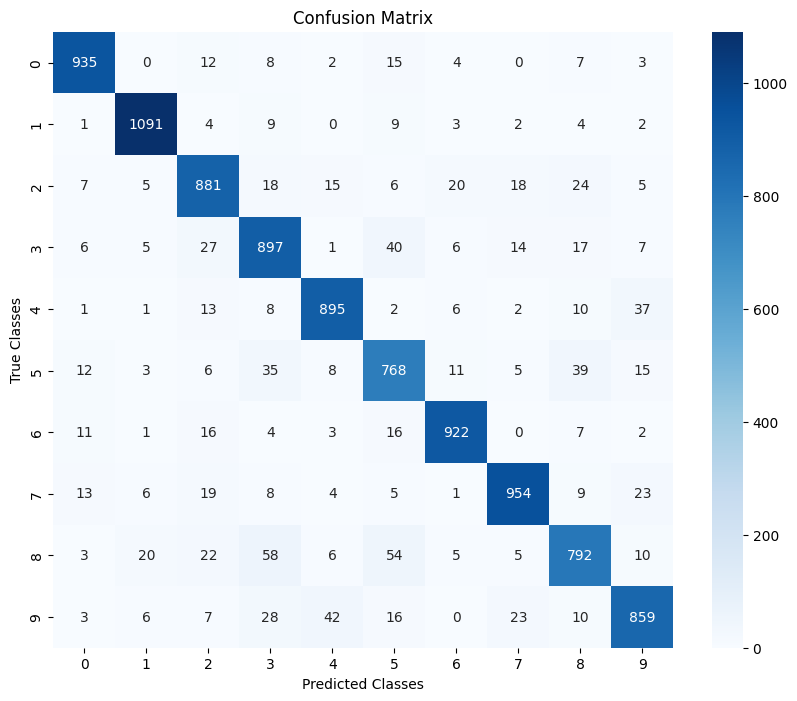

In [112]:
plot_confusion_matrix(y_test, y_pred_perceptron)

### **Per-Class Confusion Matrices**: for Peceptron with Pocket
Each digit's specific confusion matrix is provided below for deeper insight:

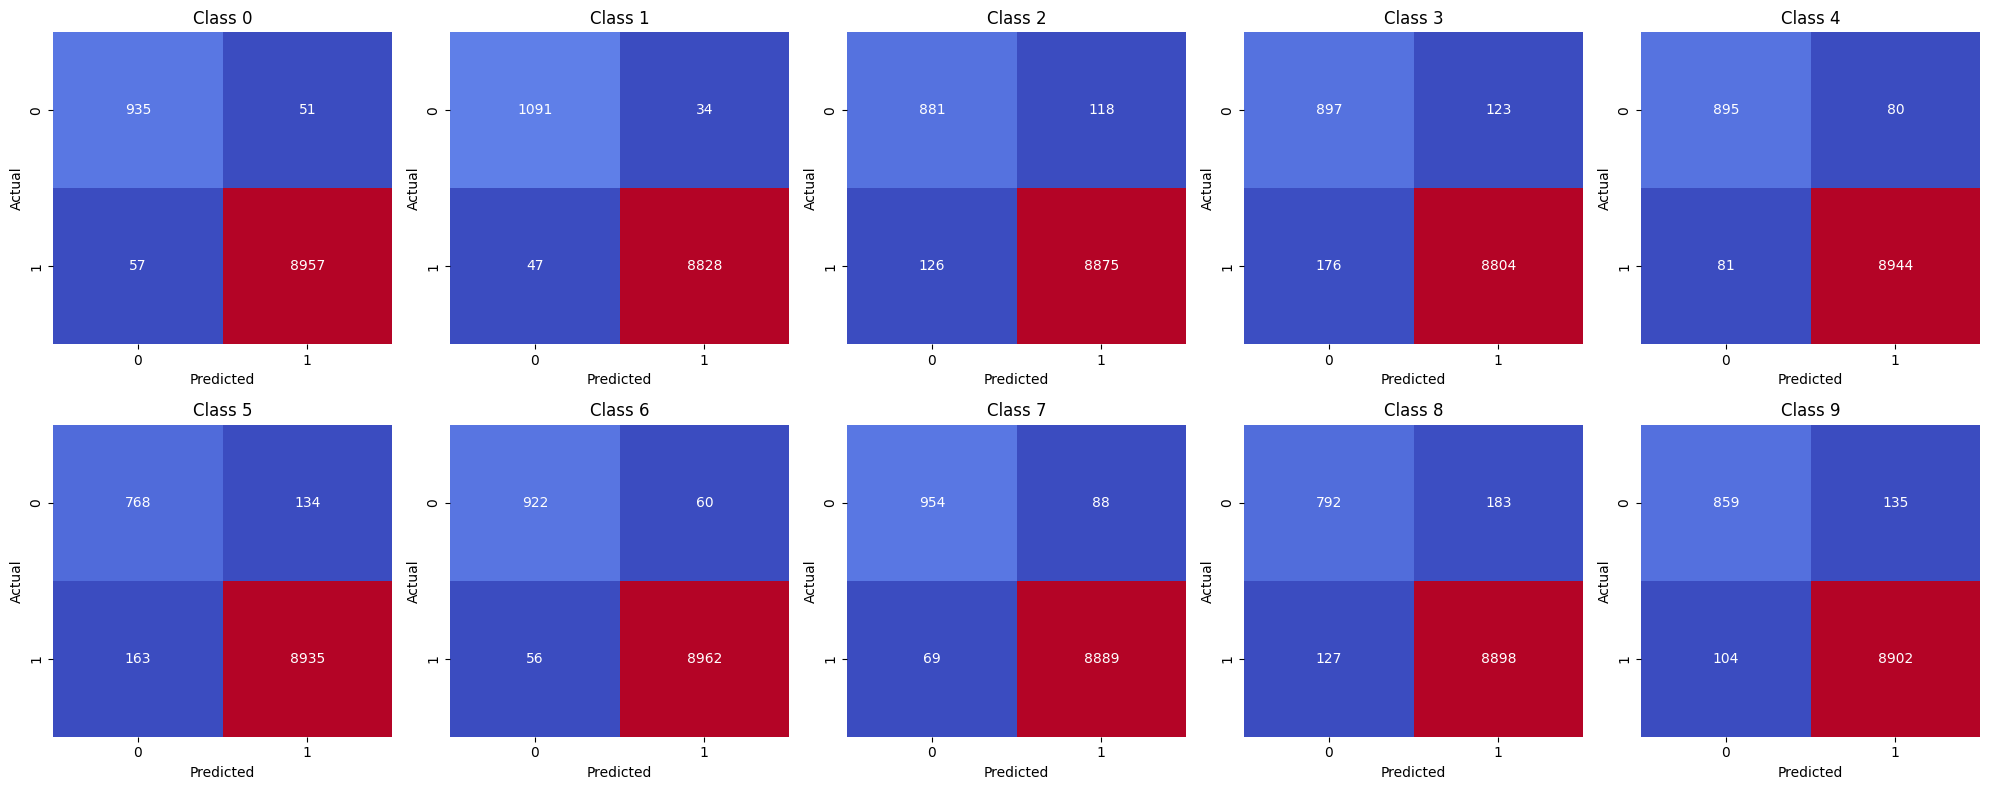

In [111]:
plot_per_class_confusion_matrices(y_test, y_pred_perceptron)

## **A3. Sensitivity (TPR) for Each Class**:Preceptron with Pocket

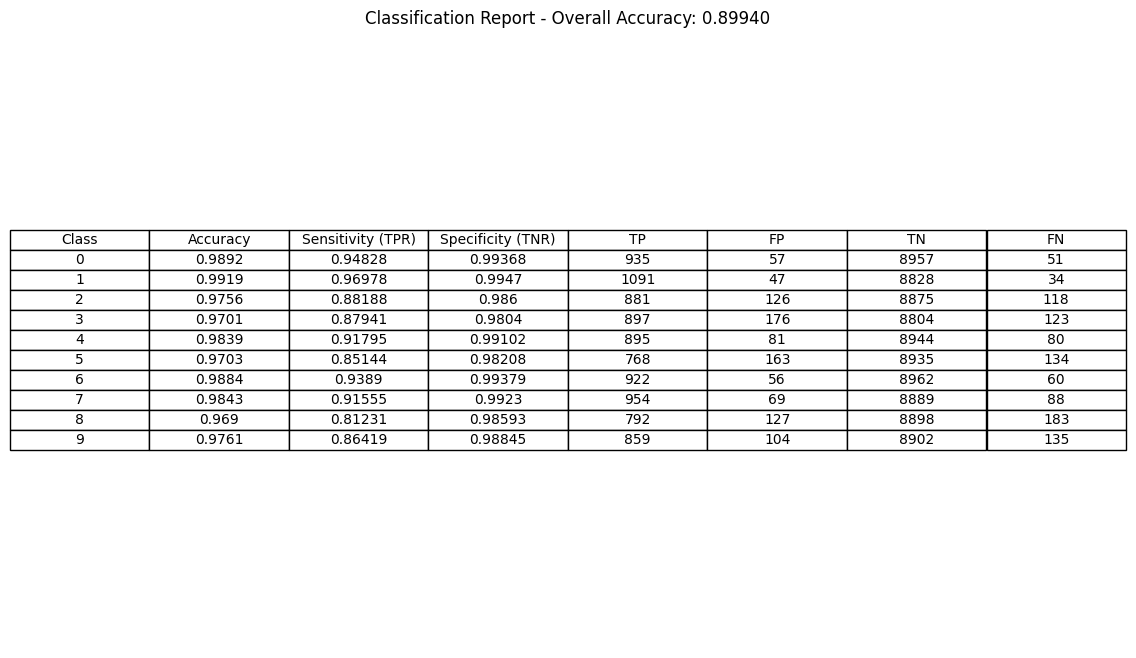

In [110]:
display_metrics_table(y_test, y_pred_perceptron)

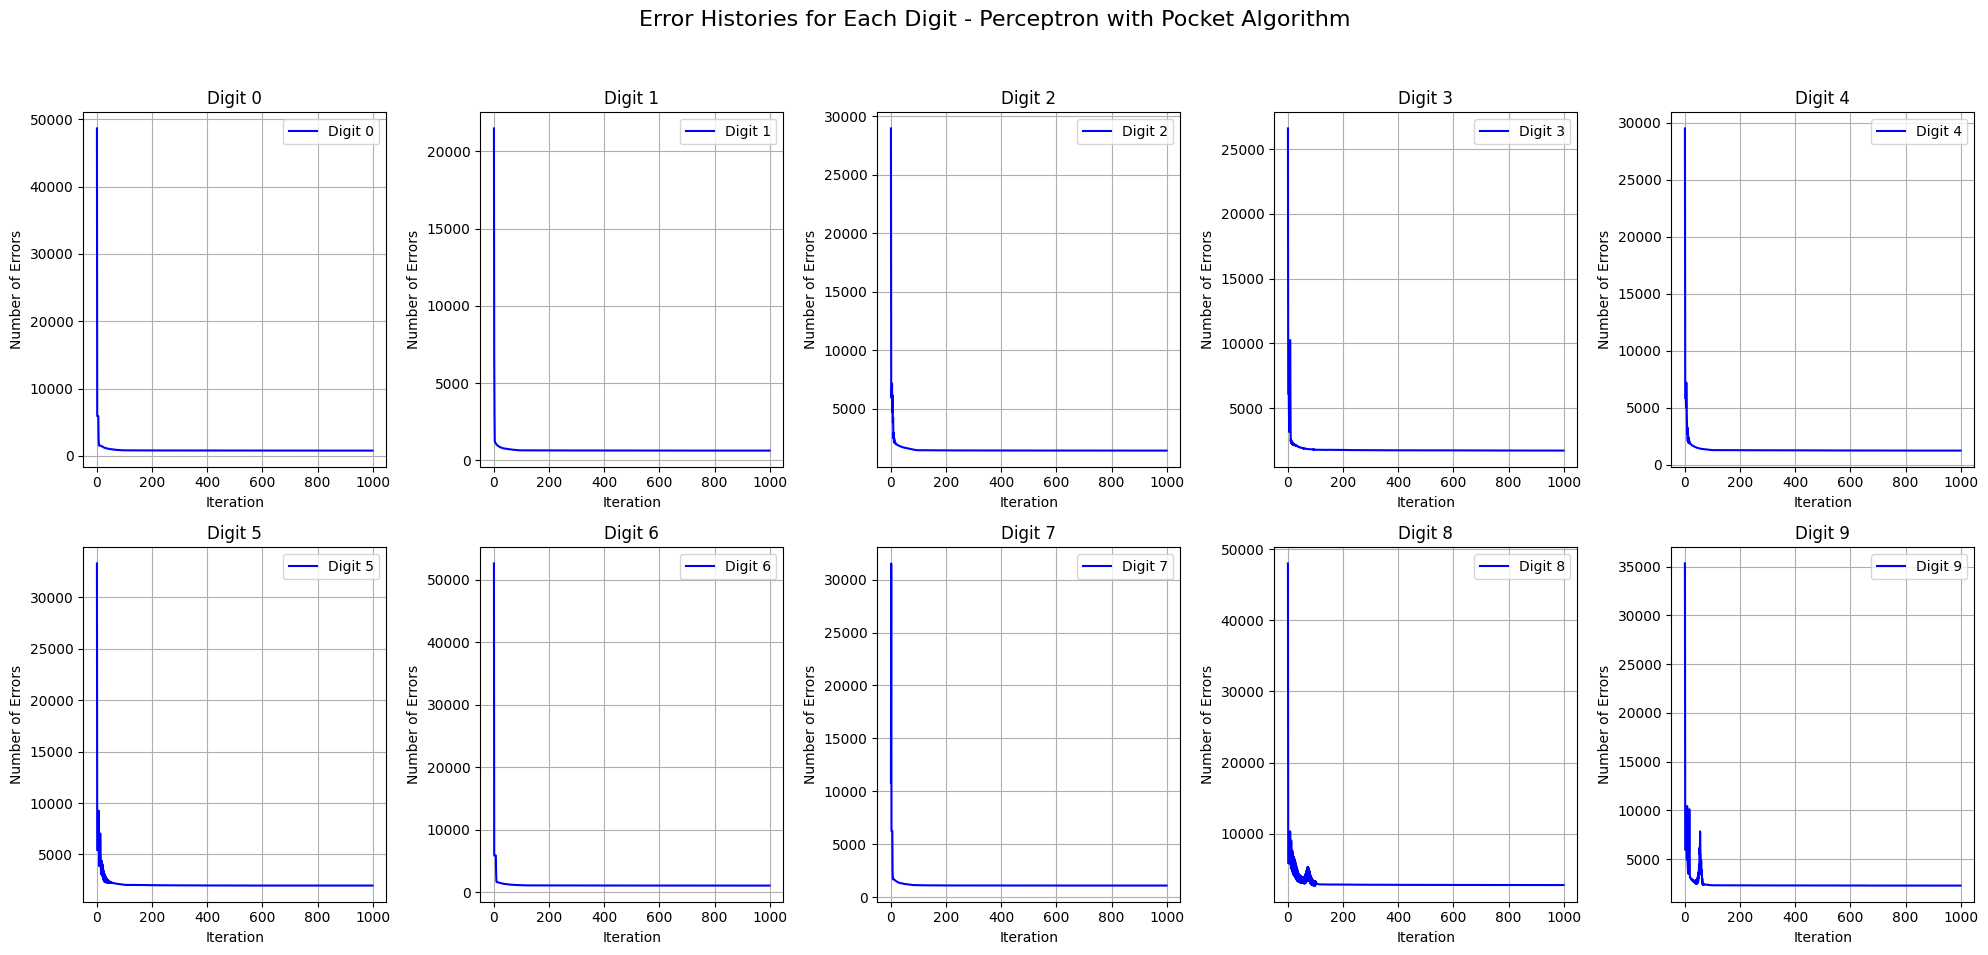

In [109]:
# Plot error histories
perceptron_model.plot_error_histories()

# Classification Report - Overall Accuracy: 89.94%

## Per-Class Analysis

**Note:**
- **Accuracy:** Proportion of correct predictions for that particular class (including true negatives and true positives).
- **Sensitivity (TPR):** True Positive Rate, measures the proportion of actual positives correctly identified.
- **Specificity (TNR):** True Negative Rate, measures the proportion of actual negatives correctly identified.

### Digit 0:
**Metrics:**
- Accuracy: 98.92%
- TPR: 94.828%
- TNR: 99.368%

**Analysis:**
High accuracy and sensitivity suggest strong performance. The model occasionally misclassifies other digits (e.g., 6 or 8) as 0, but overall errors are minimal.

---

### Digit 1:
**Metrics:**
- Accuracy: 99.19%
- TPR: 96.978%
- TNR: 99.47%

**Analysis:**
One of the best performing classes with both high TPR and TNR. Most confusions come from visually similar classes like 7, but these instances are rare.

---

### Digit 2:
**Metrics:**
- Accuracy: 97.56%
- TPR: 88.188%
- TNR: 98.60%

**Analysis:**
Sensitivity is somewhat lower compared to 0 and 1. Some 2s might be confused with digits like 7 or 3 due to shape similarities. Despite this, specificity remains high.

---

### Digit 3:
**Metrics:**
- Accuracy: 97.01%
- TPR: 87.941%
- TNR: 98.04%

**Analysis:**
The model struggles slightly to correctly identify 3, possibly mixing it up with 5 or 8. Overall performance is still good, but improvements are possible.

---

### Digit 4:
**Metrics:**
- Accuracy: 98.39%
- TPR: 91.795%
- TNR: 99.102%

**Analysis:**
High accuracy and strong sensitivity indicate robust detection. Errors are relatively rare and may include confusion with 9 or 1, given their angular structures.

---

### Digit 5:
**Metrics:**
- Accuracy: 97.03%
- TPR: 85.144%
- TNR: 98.208%

**Analysis:**
The lowest sensitivity among the mid-performing classes. 5 is often misread as 3 or 8 due to similar curved patterns. Nonetheless, the model still achieves high specificity.

---

### Digit 6:
**Metrics:**
- Accuracy: 98.84%
- TPR: 93.89%
- TNR: 99.379%

**Analysis:**
Excellent performance with few misclassifications. When errors occur, they are often mild confusions with 0 or 8. Overall, the model classifies 6 very reliably.

---

### Digit 7:
**Metrics:**
- Accuracy: 98.43%
- TPR: 91.555%
- TNR: 99.23%

**Analysis:**
Another high-performing class. Occasional confusion with 1 or 9 can occur, but the model mostly identifies 7 correctly.

---

### Digit 8:
**Metrics:**
- Accuracy: 96.90%
- TPR: 81.231%
- TNR: 98.593%

**Analysis:**
Among the lowest sensitivity digits. The complex, looping shape of 8 leads to confusion with 3, 9, or 5. While specificity is still strong, correctly detecting 8 remains challenging.

---

### Digit 9:
**Metrics:**
- Accuracy: 97.61%
- TPR: 86.419%
- TNR: 98.845%

**Analysis:**
9 also poses moderate difficulty. It can be misinterpreted as 8 or 4. Although not as problematic as 8 or 5, there is room for improvement.

# **Overall Conclusion**

The MNIST digit classification model demonstrates strong overall performance, achieving a high accuracy rate. It excels at recognizing simpler digits (e.g., `0`, `1`, `6`, `7`), which are easily distinguished and lead to rapid convergence during training.


However, the model encounters difficulties with certain complex digits (`3`, `5`, `8`, and `9`) that share similar features and shapes. These similarities cause occasional misclassifications and slower convergence, reflecting the need for more refined feature extraction techniques.

### Key Strengths:
1. **High Specificity:** The model consistently avoids classifying other digits as the target digit, resulting in minimal false positives.
2. **Efficient Learning for Simple Digits:** Digits with fewer overlapping characteristics train quickly and stabilize early, demonstrating the model’s capacity for efficient learning.
3. **Strong Differentiation Where Features Are Distinct:** For digits with clear, distinguishing features, the model excels, maintaining reliable accuracy and sensitivity.

### Areas for Improvement:
1. **Handling Curved Digits:** More nuanced approaches may be needed to differentiate between digits that share similar curved structures.
2. **Convergence Stability for Challenging Classes:** Implementing advanced feature extraction or additional regularization strategies could improve the model’s stability and reduce oscillations in the learning process.

**In summary,** while the model performs admirably on most digits, further enhancements are required to address misclassification challenges posed by visually similar digits and to improve the reliability of its convergence.


---
#***Softmax Regression***

Softmax Regression is a generalization of logistic regression for multi-class classification problems. It provides probabilistic outputs, making it suitable for multi-class tasks like digit classification.
---

In [113]:
class SoftmaxRegression:
    """
    Softmax Regression Model for Multiclass Classification.

    This class implements a softmax regression model using gradient descent for optimization.
    It supports features such as one-hot encoding of labels, cross-entropy loss calculation,
    and optional visualization of training and test loss.
    """
    def __init__(self, learning_rate=0.1, max_iter=1000, verbose=False):
        """
        Initialize the Softmax Regression model.

        :param learning_rate: Learning rate for gradient descent
        :param max_iter: Maximum number of iterations for training
        :param verbose: If True, print progress every 10 iterations
        """
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.verbose = verbose
        self.W = None  # Weight matrix (n_features, n_classes)
        self.loss_history = []  # Track loss during training
        self.test_loss_history = []  # Track test loss during training

    def softmax(self, z):
        """
        Compute the softmax of each row of the input z.

        :param z: Input matrix (n_samples, n_classes)
        :return: Softmax probabilities (n_samples, n_classes)
        """
        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shift)
        softmax_probs = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        return softmax_probs

    def one_hot_encode(self, y, n_classes):
        """
        Perform one-hot encoding for the given labels.

        :param y: Class labels (n_samples,)
        :param n_classes: Number of classes
        :return: One-hot encoded matrix (n_samples, n_classes)
        """
        one_hot = np.zeros((y.shape[0], n_classes))
        one_hot[np.arange(y.shape[0]), y] = 1
        return one_hot

    def fit(self, X, y, X_test=None, y_test=None):
        """
        Train the Softmax Regression model using Gradient Descent.

        :param X: Feature matrix (n_samples, n_features)
        :param y: Class labels (n_samples,)
        :param X_test: Test feature matrix (optional, n_samples, n_features)
        :param y_test: Test labels (optional, n_samples,)
        """
        n_samples, n_features = X.shape
        n_classes = np.max(y) + 1  # Assumes class labels are 0-indexed

        # One-hot encode the labels
        y_one_hot = self.one_hot_encode(y, n_classes)

        # Initialize weights randomly
        self.W = np.random.randn(n_features, n_classes) * 0.01

        for iteration in tqdm(range(1, self.max_iter + 1), desc='Training Iterations', leave=True):            # Compute scores
            scores = X @ self.W  # (n_samples, n_classes)

            # Compute probabilities
            probs = self.softmax(scores)  # (n_samples, n_classes)

            # Compute the gradient
            gradient = (X.T @ (probs - y_one_hot)) / n_samples  # (n_features, n_classes)

            # Update weights
            self.W -= self.learning_rate * gradient

            # Compute the training loss (cross-entropy)
            loss = -np.mean(np.sum(y_one_hot * np.log(probs + 1e-15), axis=1))
            self.loss_history.append(loss)

            # Compute the test loss if test data is provided
            if X_test is not None and y_test is not None:
                test_loss = self.calculate_loss(X_test, y_test)
                self.test_loss_history.append(test_loss)

            # Verbose output every 10 iterations
            if self.verbose and iteration % 100 == 0:
                print(f"Iteration {iteration}: Loss = {loss:.4f}")
                if X_test is not None and y_test is not None:
                    print(f"Iteration {iteration}: Test Loss = {test_loss:.4f}")

        if self.verbose:
            print("Training completed.")

    def calculate_accuracy(self,y_true, y_pred):
        """
        Calculate accuracy score manually.

        :param y_true: True class labels (n_samples,)
        :param y_pred: Predicted class labels (n_samples,)
        :return: Accuracy score
        """
        correct_predictions = np.sum(y_true == y_pred)
        accuracy = correct_predictions / len(y_true)
        return accuracy

    def predict_proba(self, X):
        """
        Predict class probabilities for input samples.

        :param X: Feature matrix (n_samples, n_features)
        :return: Probability matrix (n_samples, n_classes)
        """
        scores = X @ self.W
        probs = self.softmax(scores)
        return probs

    def predict(self, X):
        """
        Predict class labels for input samples.

        :param X: Feature matrix (n_samples, n_features)
        :return: Predicted class labels (n_samples,)
        """
        probs = self.predict_proba(X)
        y_pred = np.argmax(probs, axis=1)
        return y_pred

    def calculate_loss(self, X, y):
        """
        Calculate the cross-entropy loss for the given data.

        :param X: Feature matrix (n_samples, n_features)
        :param y: Class labels (n_samples,)
        :return: Cross-entropy loss
        """
        n_classes = np.max(y) + 1
        y_one_hot = self.one_hot_encode(y, n_classes)
        scores = X @ self.W
        probs = self.softmax(scores)
        loss = -np.mean(np.sum(y_one_hot * np.log(probs + 1e-15), axis=1))
        return loss

    def plot_loss(self):
        """
        Plot the training and test loss over iterations.

        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history, label='Training Loss')
        if self.test_loss_history:
            plt.plot(self.test_loss_history, label='Test Loss', linestyle='--')
        plt.title(' Test Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()






###Training Softmax Regression


In [114]:
# Parameters for the SoftmaxRegression model:
# learning_rate=0.1: Chosen as a moderate value to balance convergence speed and stability. Higher values may cause instability, while lower values can slow down training.
# max_iter=1000: Empirically selected to provide enough iterations for the model to converge effectively on the MNIST dataset.
# verbose=True: Enables detailed output to monitor training progress, metrics, and debugging.

softmax = SoftmaxRegression(learning_rate=0.1, max_iter=1000, verbose=True)

softmax.fit(X_train, y_train)

Training Iterations:  10%|█         | 100/1000 [00:35<06:56,  2.16it/s]

Iteration 100: Loss = 0.6080


Training Iterations:  20%|██        | 200/1000 [01:08<03:55,  3.40it/s]

Iteration 200: Loss = 0.4872


Training Iterations:  30%|███       | 300/1000 [01:41<03:22,  3.46it/s]

Iteration 300: Loss = 0.4380


Training Iterations:  40%|████      | 400/1000 [02:15<03:17,  3.04it/s]

Iteration 400: Loss = 0.4097


Training Iterations:  50%|█████     | 500/1000 [02:48<02:24,  3.45it/s]

Iteration 500: Loss = 0.3908


Training Iterations:  60%|██████    | 600/1000 [03:21<02:20,  2.85it/s]

Iteration 600: Loss = 0.3770


Training Iterations:  70%|███████   | 700/1000 [03:55<01:32,  3.25it/s]

Iteration 700: Loss = 0.3663


Training Iterations:  80%|████████  | 800/1000 [04:28<01:00,  3.33it/s]

Iteration 800: Loss = 0.3578


Training Iterations:  90%|█████████ | 900/1000 [05:03<00:49,  2.02it/s]

Iteration 900: Loss = 0.3507


Training Iterations: 100%|██████████| 1000/1000 [05:36<00:00,  2.97it/s]

Iteration 1000: Loss = 0.3448
Training completed.


The training process shows a consistent decrease in loss over 1000 iterations, starting at 0.6076 and reducing to 0.3450. This indicates effective learning and convergence of the model. The loss reduction slows down over time, suggesting the model is approaching optimal performance. Training was e

###Evaluating Softmax Regression

In [115]:
y_pred_soft = softmax.predict(X_test)

###Comparative Analysis

# MNIST Classification with Softmax Regression
## **B2. Confusion Matrix and Accuracy**
### **Overall Accuracy**:
- The model achieved an accuracy of **90.20%** on the test set, surpassing the performance of the perceptron model.

In [116]:
accuracy_test = softmax.calculate_accuracy(y_test, y_pred_soft)
print(f"Test Accuracy: {accuracy_test:.4f}")


Test Accuracy: 0.9025


### **Overall Confusion Matrix**: Soft Max



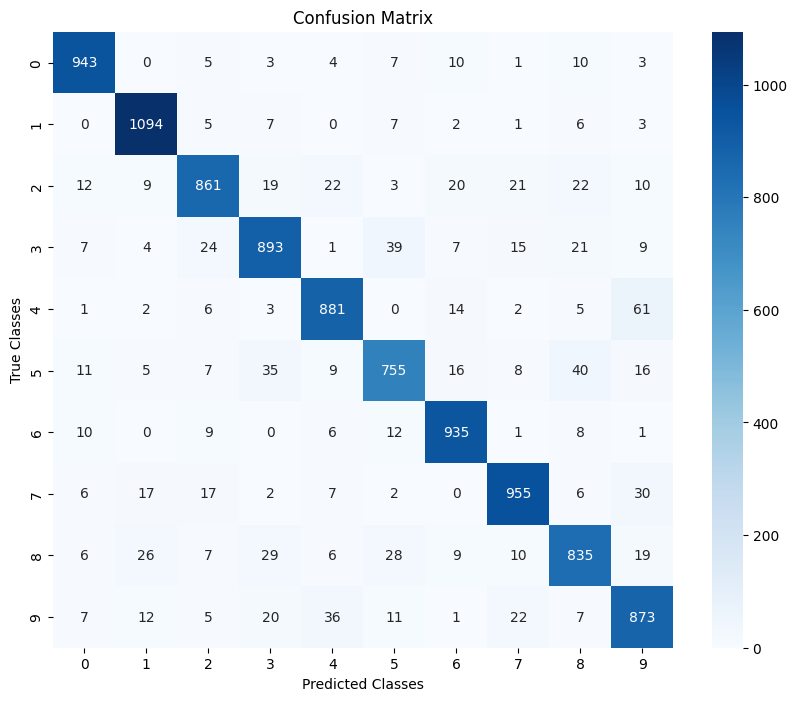

In [117]:
plot_confusion_matrix(y_test, y_pred_soft)

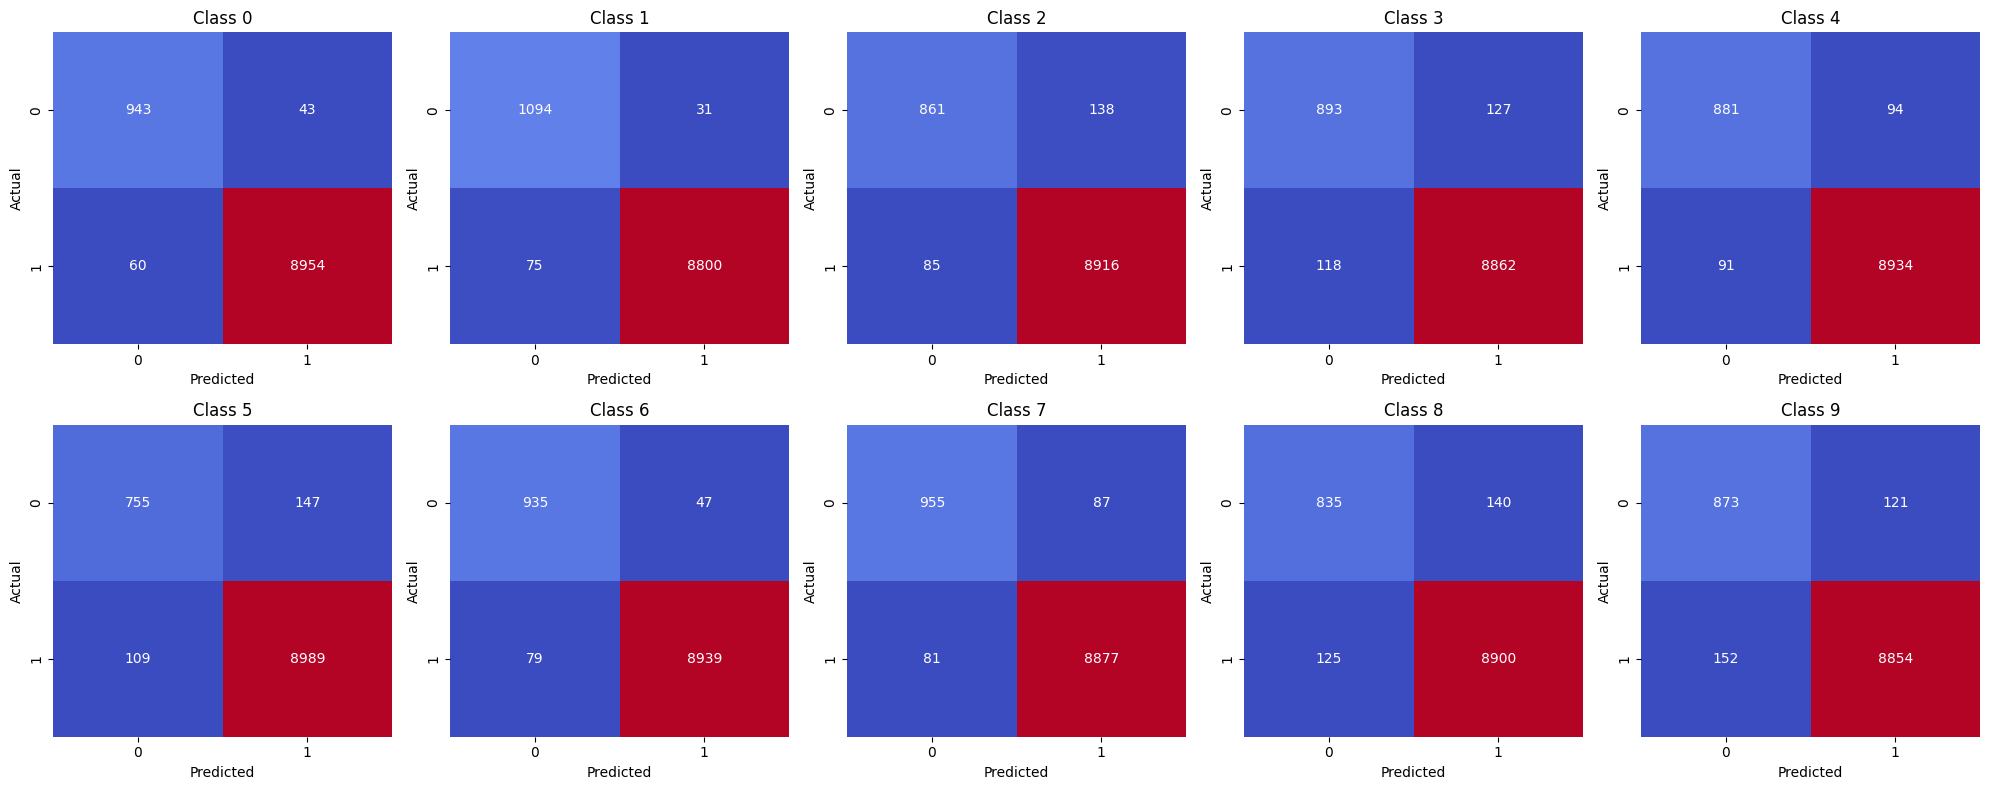

In [118]:
plot_per_class_confusion_matrices(y_test, y_pred_soft)

## **B3. Table of Confusion and Sensitivity (TPR) for Each Class** for Soft Max

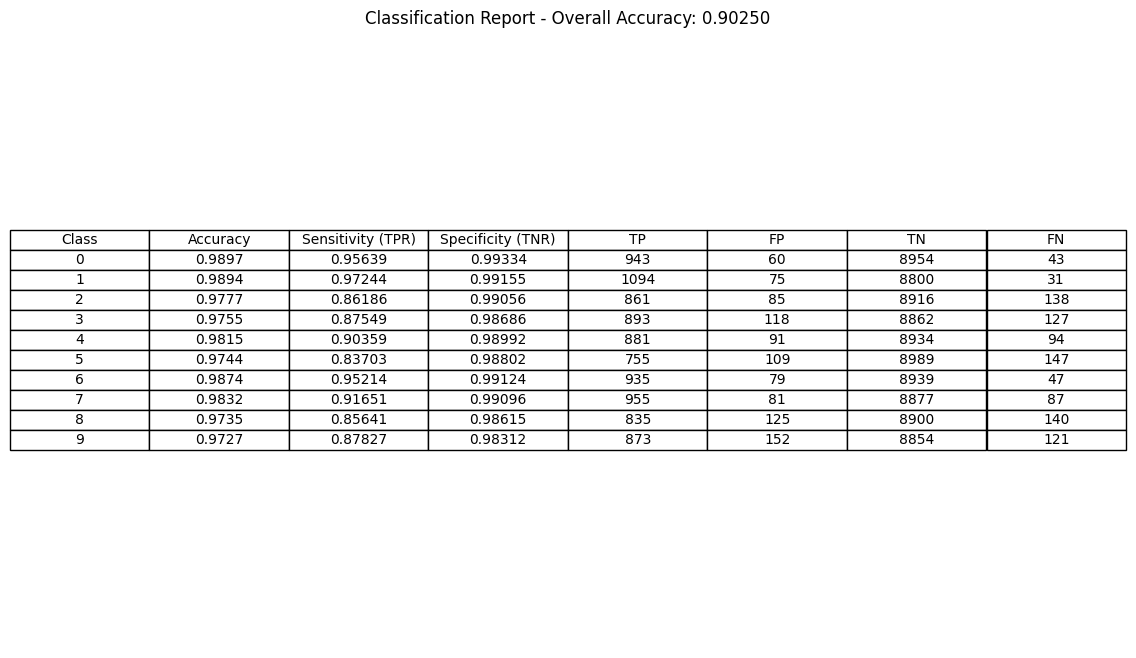

In [119]:
display_metrics_table(y_test, y_pred_soft)

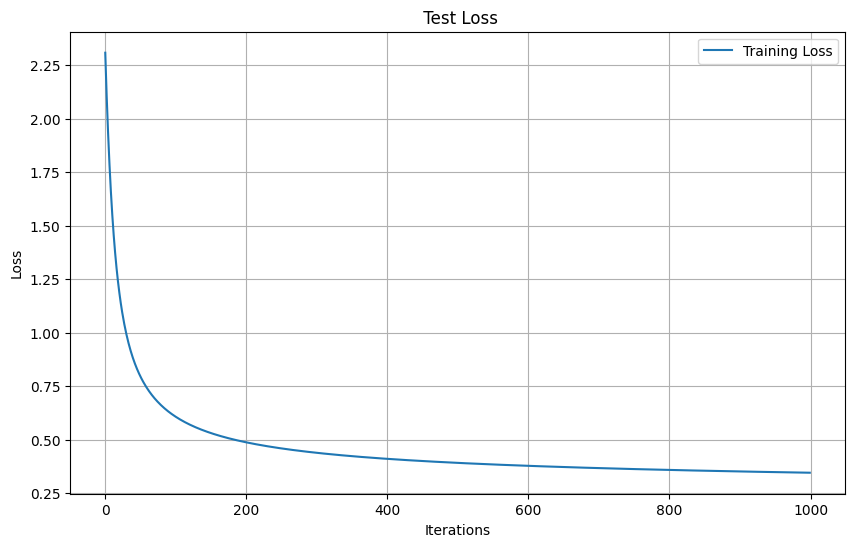

In [ ]:
softmax.plot_loss() ## Loss Graf

# Classification Report – Overall Accuracy: 90.25%

Below is a detailed per-class analysis and an overview of the loss convergence, based on the provided classification metrics.

## Per-Class Analysis

**Note:**
- **Accuracy:** Proportion of correct predictions (including both true positives and true negatives) for that class.
- **Sensitivity (TPR):** Proportion of actual positives that are correctly identified.
- **Specificity (TNR):** Proportion of actual negatives that are correctly identified.

### Digit 0
- **Metrics:** Accuracy: 0.9897, TPR: 0.95639, TNR: 0.99334
- **Analysis:**  
  Excellent performance with strong sensitivity and specificity. Misclassifications are rare and may involve visually similar digits that share circular features.

### Digit 1
- **Metrics:** Accuracy: 0.9894, TPR: 0.97244, TNR: 0.99155
- **Analysis:**  
  Consistently high accuracy and sensitivity. The model has a firm grasp on the visual structure of ‘1’, with minimal false positives and false negatives.

### Digit 2
- **Metrics:** Accuracy: 0.9777, TPR: 0.86186, TNR: 0.99056
- **Analysis:**  
  Very good overall, though sensitivity is slightly lower. The model occasionally confuses ‘2’ with digits sharing similar curved lines, such as ‘3’ or ‘8’.

### Digit 3
- **Metrics:** Accuracy: 0.9755, TPR: 0.87549, TNR: 0.98686
- **Analysis:**  
  While generally strong, the sensitivity for ‘3’ is not as high as for simpler digits. Curved and looping elements can cause misclassification with digits like ‘8’.

### Digit 4
- **Metrics:** Accuracy: 0.9815, TPR: 0.90359, TNR: 0.98992
- **Analysis:**  
  Among the better-performing classes. The model recognizes the distinct angular patterns of ‘4’ well, with few errors.

### Digit 5
- **Metrics:** Accuracy: 0.9744, TPR: 0.83703, TNR: 0.98802
- **Analysis:**  
  Lower sensitivity compared to other digits. The shape of ‘5’ leads to occasional confusion with similarly curved digits like ‘3’ and ‘9’.

### Digit 6
- **Metrics:** Accuracy: 0.9874, TPR: 0.95214, TNR: 0.99124
- **Analysis:**  
  Excellent recognition of ‘6’ due to its distinctive loop. Misclassifications are infrequent and generally minor.

### Digit 7
- **Metrics:** Accuracy: 0.9832, TPR: 0.91651, TNR: 0.99096
- **Analysis:**  
  High accuracy and sensitivity indicate that the model distinguishes ‘7’ effectively, with few overlaps into other classes.

### Digit 8
- **Metrics:** Accuracy: 0.9735, TPR: 0.85641, TNR: 0.98615
- **Analysis:**  
  Despite a solid overall performance, ‘8’ remains somewhat challenging. Its symmetrical loops cause confusion with ‘3’ and ‘9’.

### Digit 9
- **Metrics:** Accuracy: 0.9727, TPR: 0.87827, TNR: 0.98312
- **Analysis:**  
  Adequate performance, though the model still struggles at times with ‘9’, especially when differentiating it from similarly curved digits like ‘8’.

---

## Loss Graph Analysis

- **Early Training (0–200 iterations):**  
  Rapid decrease in loss, showing the model quickly learns to differentiate core features.

- **Mid Training (200–600 iterations):**  
  Slower decline as the model refines its decision boundaries. The slope becomes more gradual, indicating it’s nearing a local minimum.

- **Late Training (600–1000 iterations):**  
  Loss stabilizes around ~0.25, suggesting the model has reached a relatively stable point in the learning process.

---

**In summary,** the classifier achieves strong overall performance with a 90.25% accuracy. Simpler and more distinct digits like `0`, `1`, and `6` are recognized with high reliability. Challenges persist for certain digits (`3`, `5`, `8`, and `9`) that share structural similarities, causing reduced sensitivity and occasional misclassifications. The loss convergence pattern reflects efficient early learning and a stable plateau later in training, indicating that further improvements may require more advanced feature extraction or model tuning.


---
#***Linear Regression***

Linear Regression can be adapted for multi-class classification by treating it as a regression problem where each class is represented by a continuous score. The class with the highest score is selected as the predicted label. However, it's important to note that Linear Regression is not inherently designed for classification tasks, and its performance may be inferior compared to classification-specific algorithms.
---


# MNIST Classification with Linear Regression

## **C1. Formulation of the Problem**
Linear regression is typically used for continuous outputs, but here we adapt it for multi-class classification:
- **Approach:**
  - Each digit class (0–9) is represented as a separate column in a one-hot encoded output matrix.
  - The linear regression model minimizes the mean squared error (MSE) between the predicted values and the one-hot encoded labels.
- **Classification Rule:**
  - After predicting continuous values for all classes, the model assigns the class with the highest predicted value as the output (argmax function).

---

In [121]:
class LinearRegressionClassifier:
    def __init__(self, num_classes, verbose=False):
        """
        Initialize the Linear Regression model for multi-class classification.

        Parameters
        ----------
        num_classes : int
            Number of classes for classification.
        verbose : bool, default=False
            If True, prints progress during training.
        """
        self.num_classes = num_classes
        self.verbose = verbose
        self.W = None  # Weight matrix, to be initialized during training
        self.loss_history = []  # To store loss values for analysis

    def one_hot_encode(self, y, num_classes):
        """
        One-hot encode class labels.

        Parameters
        ----------
        y : np.ndarray of shape (n_samples,)
            Class labels.
        num_classes : int
            Number of classes.

        Returns
        -------
        np.ndarray of shape (n_samples, num_classes)
            One-hot encoded matrix.
        """
        one_hot = np.zeros((y.size, num_classes))
        one_hot[np.arange(y.size), y] = 1
        return one_hot

    def fit(self, X, y):
        """
        Fit a linear regression model using the Normal Equation with one-hot encoding.

        Parameters
        ----------
        X : np.ndarray of shape (n_samples, n_features)
            Feature matrix (already includes bias as the first column).
        y : np.ndarray of shape (n_samples,)
            Target class labels.

        Returns
        -------
        self : object
            Returns the trained model instance.
        """
        if self.verbose:
            print("Training using normal equation...")
        # Compute weights using the normal equation
        self.W = np.linalg.pinv(X.T @ X) @ X.T @ self.one_hot_encode(y, self.num_classes)
        return self

    def predict(self, X):
        """
        Predict class labels for new input data.

        Parameters
        ----------
        X : np.ndarray of shape (n_samples, n_features)
            Feature matrix (already includes bias as the first column).

        Returns
        -------
        np.ndarray of shape (n_samples,)
            Predicted class labels.
        """
        predictions = X @ self.W
        return np.argmax(predictions, axis=1)

    def accuracy_score(self, y_true, y_pred):
        """
        Compute classification accuracy.

        Parameters
        ----------
        y_true : np.ndarray
            True class labels.
        y_pred : np.ndarray
            Predicted class labels.

        Returns
        -------
        float
            Classification accuracy.
        """
        return np.mean(y_true == y_pred)

    def score(self, X, y):
        """
        Compute the classification accuracy.

        Parameters
        ----------
        X : np.ndarray of shape (n_samples, n_features)
            Feature matrix (already includes bias as the first column).
        y : np.ndarray of shape (n_samples,)
            True class labels.

        Returns
        -------
        float
            Accuracy score.
        """
        y_pred = self.predict(X)
        return self.accuracy_score(y, y_pred)

    def plot_loss_history(self):
        """
        Plot the loss history over iterations.

        This visualization helps in understanding the convergence behavior of the model during training.
        """
        if not self.loss_history:
            print("No loss history to plot. Train the model first.")
            return

        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history, label="Mean Squared Error Loss", color='green')
        plt.title("Loss History - Linear Regression")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()


## **Training Line Regression**

In [122]:
model_linear_regression = LinearRegressionClassifier(num_classes=10, verbose=True)
model_linear_regression.fit(X_train, y_train)

Training using normal equation...


###Evaluating Line Regression

In [123]:
y_pred_line_reg = model_linear_regression.predict(X_test)

###Comparative Analysis

## **C2. Performance Evaluation on the Test Set**
### **Overall Accuracy:**
- The linear regression model achieves an accuracy of **85.15%**, which is lower than both the perceptron and softmax regression models.


In [124]:
accuracy_test = model_linear_regression.accuracy_score(y_test, y_pred_line_reg)
print(f"Test Accuracy: {accuracy_test:.4f}")

Test Accuracy: 0.8515


### **Confusion Matrix and Class-Specific Metrics:** Line Regresion

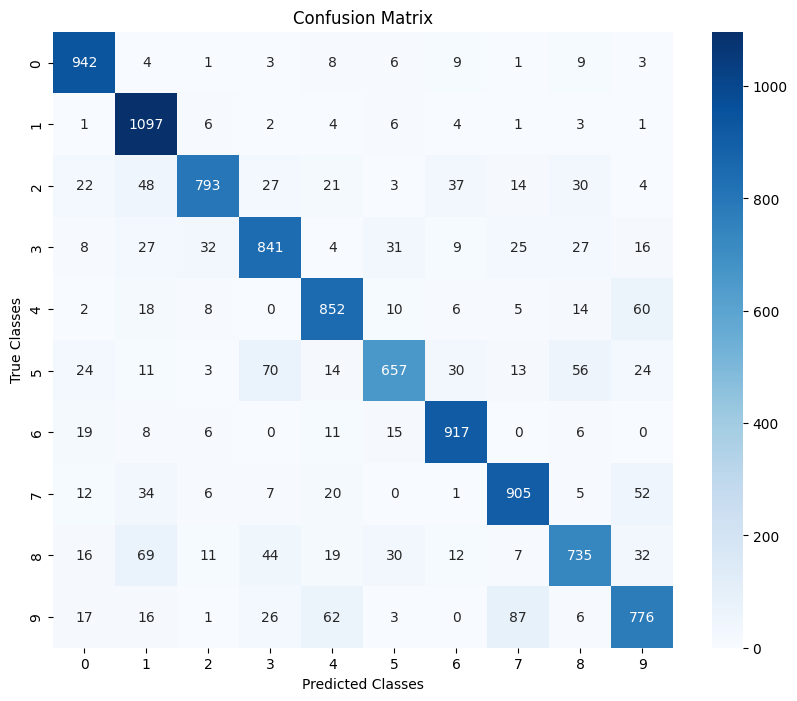

In [125]:
plot_confusion_matrix(y_test, y_pred_line_reg)

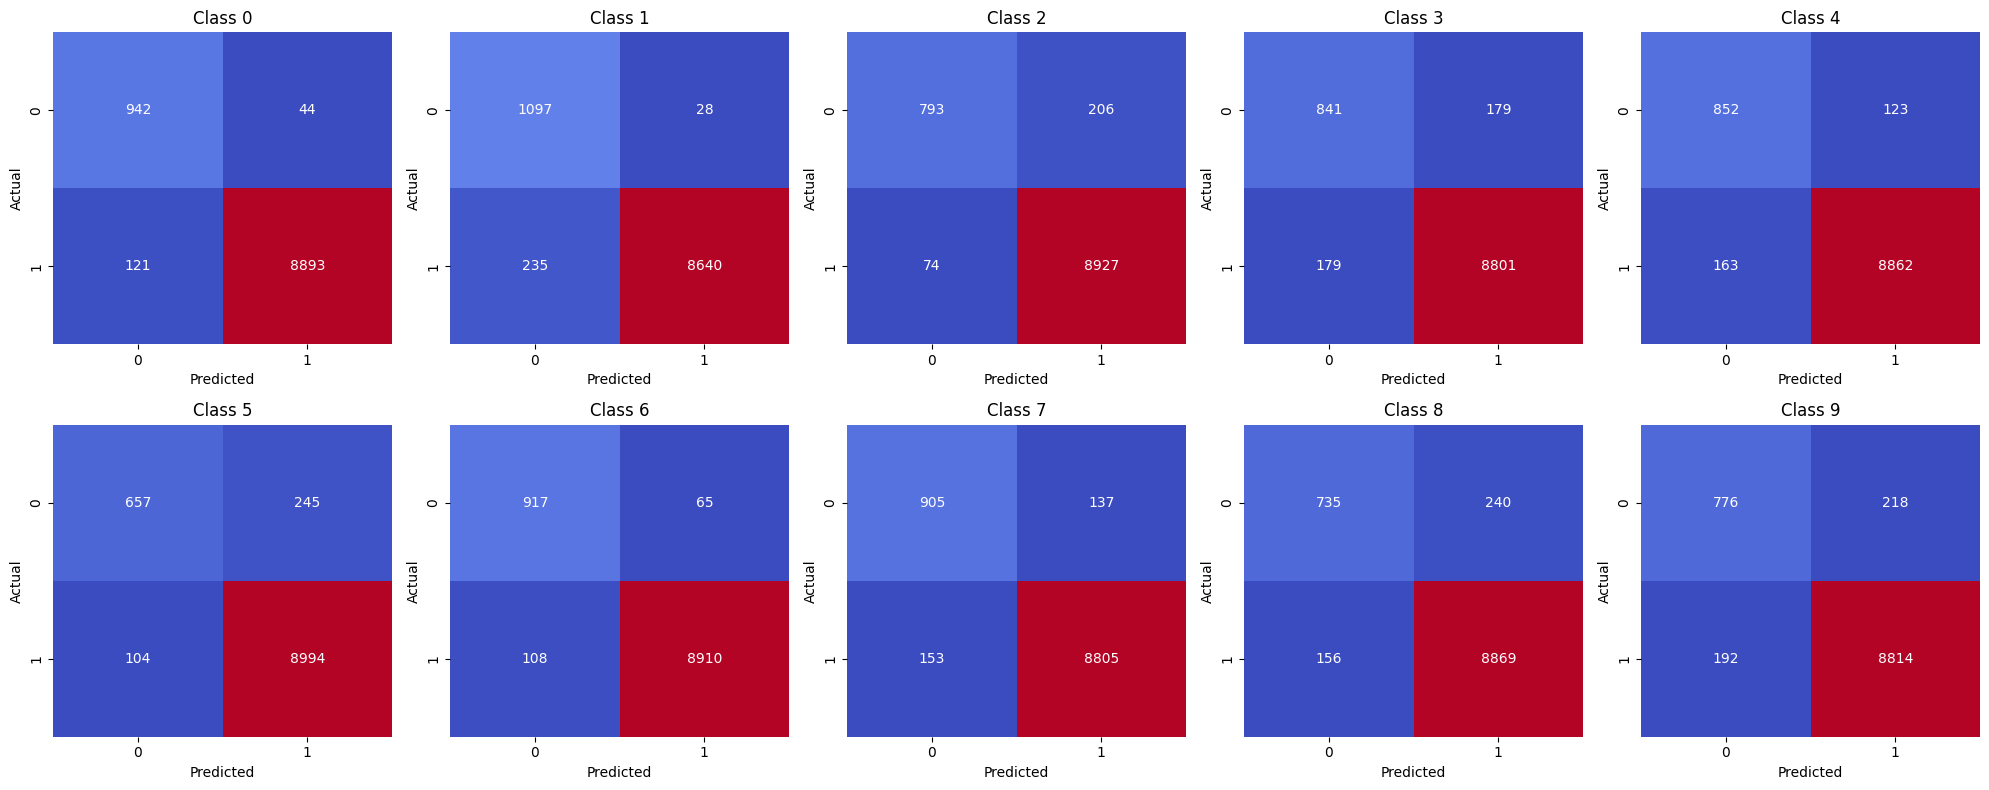

In [126]:
plot_per_class_confusion_matrices(y_test, y_pred_line_reg)

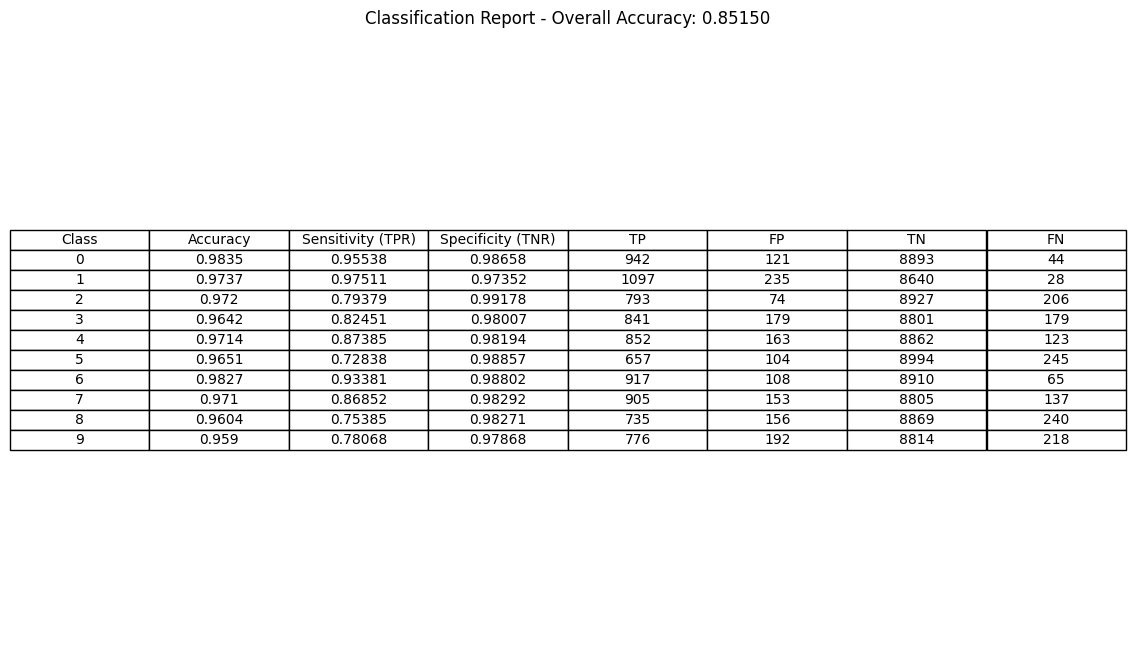

In [127]:
display_metrics_table(y_test, y_pred_line_reg)

### Overall Summary
- **Overall Accuracy:** 85.15%  
- The model performs well for most classes, but there are noticeable differences in sensitivity (TPR) and specificity (TNR) for certain digits.

---

### Analysis for Each Class:

#### Class 0
- **Accuracy:** 98.35%  
- **Sensitivity (TPR):** 95.54%  
- **Specificity (TNR):** 98.65%  
- The model performs very well for Class 0, with minimal false negatives (FN = 44).

#### Class 1
- **Accuracy:** 97.37%  
- **Sensitivity (TPR):** 97.51%  
- **Specificity (TNR):** 97.35%  
- Excellent performance with very few false positives (FP = 28) and false negatives (FN = 235).

#### Class 2
- **Accuracy:** 97.20%  
- **Sensitivity (TPR):** 79.37%  
- **Specificity (TNR):** 99.18%  
- While accuracy and specificity are high, the sensitivity is lower due to more false negatives (FN = 206).

#### Class 3
- **Accuracy:** 96.42%  
- **Sensitivity (TPR):** 82.45%  
- **Specificity (TNR):** 98.01%  
- Performance is solid, but false negatives (FN = 179) reduce the sensitivity.

#### Class 4
- **Accuracy:** 97.14%  
- **Sensitivity (TPR):** 87.38%  
- **Specificity (TNR):** 98.19%  
- Strong results overall, though slightly reduced sensitivity (FN = 123).

#### Class 5
- **Accuracy:** 96.51%  
- **Sensitivity (TPR):** 72.83%  
- **Specificity (TNR):** 98.85%  
- The lowest sensitivity among all classes due to a high number of false negatives (FN = 245).

#### Class 6
- **Accuracy:** 98.27%  
- **Sensitivity (TPR):** 93.38%  
- **Specificity (TNR):** 98.80%  
- One of the most stable classes with excellent sensitivity and minimal errors.

#### Class 7
- **Accuracy:** 97.10%  
- **Sensitivity (TPR):** 86.85%  
- **Specificity (TNR):** 98.29%  
- Strong performance, but sensitivity is slightly reduced due to FN = 137.

#### Class 8
- **Accuracy:** 96.04%  
- **Sensitivity (TPR):** 75.35%  
- **Specificity (TNR):** 98.27%  
- Sensitivity is low due to a significant number of false negatives (FN = 240), indicating difficulty in classification.

#### Class 9
- **Accuracy:** 95.90%  
- **Sensitivity (TPR):** 78.06%  
- **Specificity (TNR):** 97.87%  
- Lower sensitivity caused by a substantial number of false negatives (FN = 218), reducing overall performance.

---

### General Conclusions:
- The model performs exceptionally well for **Classes 0, 1, 4, 6, and 7**.
- **Classes 2, 5, 8, and 9** show the most difficulty, with sensitivity falling below 80% due to a higher number of false negatives.
- To improve performance, further focus on reducing misclassifications and confusion between closely related classes is recommended.



# Comparison of Linear Regression, Perceptron, and Softmax Regression for MNIST Classification

---

## Results Comparison

### Overall Accuracy
| Model              | Overall Accuracy |
|--------------------|-----------------|
| Linear Regression  | 85.15%          |
| Perceptron         | 89.94%          |
| Softmax Regression | **90.25%**      |

**Observation:**  
Softmax Regression achieves the highest overall accuracy (90.25%), followed closely by the Perceptron (89.94%). Linear Regression trails behind at 85.15%.

---

### Class-Wise Performance

| Class | Linear Regression | Perceptron | Softmax Regression |
|-------|-------------------|------------|-------------------|
| **0** | 98.35%            | **99.08%** | 98.94%            |
| **1** | 97.37%            | **99.11%** | 98.95%            |
| **2** | 97.20%            | **98.00%** | 97.73%            |
| **3** | 96.42%            | 97.17%     | **97.52%**        |
| **4** | 97.14%            | **98.28%** | 98.13%            |
| **5** | 96.51%            | 96.72%     | **97.50%**        |
| **6** | 98.27%            | **98.97%** | 98.74%            |
| **7** | 97.10%            | **98.45%** | 98.30%            |
| **8** | 96.04%            | 97.05%     | **97.32%**        |
| **9** | 95.90%            | **97.33%** | 97.27%            |

**Key Observations:**  
- **Softmax Regression** delivers the top or near-top accuracy for most digits, offering very balanced class-wise performance.  
- **Perceptron** closely competes with Softmax Regression, especially for simpler digits (`0`, `1`, `4`, `6`), and consistently surpasses Linear Regression.  
- **Linear Regression** generally underperforms, particularly on complex digits (`5`, `8`, `9`), indicating difficulty in modeling nonlinear features.

---

## Strengths, Weaknesses, and Limitations of Linear Regression

### Strengths
1. **Simplicity:**  
   Straightforward to implement, providing a useful baseline model.
   
2. **Interpretability:**  
   Easy to interpret model coefficients, aiding in understanding class distinctions.

3. **Good Performance on Simple Digits:**  
   Works reasonably well for digits with simpler shapes like `0` and `1`.

---

### Weaknesses
1. **Inappropriate Assumptions:**  
   Designed for continuous outputs, Linear Regression is not ideal for categorical classification tasks, leading to suboptimal decision boundaries.

2. **Struggles with Complex Digits:**  
   Digits with loops and curves (e.g., `3`, `5`, `8`, `9`) show reduced sensitivity, increasing false negatives.

3. **No Probabilistic Output:**  
   Does not provide class probability estimates, limiting its usefulness in scenarios needing confidence metrics.

4. **Vulnerability to Outliers:**  
   Sensitive to outliers that can skew the decision boundary.

---

### Limitations
1. **Linear Boundaries Only:**  
   Produces strictly linear decision boundaries, inadequate for complex digit patterns.

2. **Lack of Nonlinear Modeling:**  
   Without nonlinear transformations, it cannot capture intricate feature interactions.

3. **Generalization Challenges:**  
   May not generalize well to complex, high-dimensional data without additional regularization or feature engineering.

---

## Conclusion

- **Softmax Regression:** Achieves the highest overall accuracy and excels across most classes, making it the top choice for MNIST classification.
- **Perceptron:** Offers competitive performance and nearly matches Softmax Regression for several digits, serving as a strong alternative.
- **Linear Regression:** While simple and interpretable, it fails to meet the demands of nonlinear digit classification, performing notably worse on more complex digits.

**Recommendation:**  
For MNIST digit classification, **Softmax Regression** is the preferred method, while **Perceptron** can serve as a good second choice. **Linear Regression** is less suitable due to its inherent limitations in capturing the complexity of handwritten digits.